In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
import os
from sklearn.preprocessing import StandardScaler
import joblib

# Add project root to path for imports
sys.path.append(os.path.abspath('..'))

# Set plotting style
sns.set_theme()  # Use seaborn's default theme
sns.set_palette("husl")  # Set the color palette

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Constants
INITIAL_CAPITAL = 100000  # Initial capital in INR
RISK_FREE_RATE = 0.0  # Using 0% as risk-free rate for simplicity


In [2]:
# Create directories if they don't exist
os.makedirs('../models', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)

# Load and prepare the data
df = pd.read_csv('../data/final_model_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Process each stock separately to avoid lookahead bias
processed_dfs = []
for ticker in df['Ticker'].unique():
    # Get data for this ticker
    ticker_data = df[df['Ticker'] == ticker].copy()
    ticker_data = ticker_data.sort_values('Date')  # Ensure chronological order
    
    # Calculate derived features
    ticker_data['HL_Range'] = (ticker_data['High'] - ticker_data['Low']) / ticker_data['Close']
    ticker_data['Volume_1d_chg'] = ticker_data['Volume'].pct_change()
    ticker_data['Price_1d_chg'] = ticker_data['Close'].pct_change()
    
    # Fill NaN values
    ticker_data = ticker_data.fillna(method='ffill')
    ticker_data = ticker_data.fillna(0)  # Fill any remaining NaNs with 0
    
    processed_dfs.append(ticker_data)

# Combine all processed data
df = pd.concat(processed_dfs, axis=0)
df = df.sort_values(['Date', 'Ticker'])

# Define feature columns
feature_columns = [
    # Technical Indicators
    'RSI', 'EMA10', 'EMA50', 'MACD', 'MACD_Signal', 'MACD_Hist',
    # Price and Volume
    'Volume', 'Close', 'High', 'Low',
    # Derived Features
    'HL_Range', 'Volume_1d_chg', 'Price_1d_chg'
]

# Prepare features (X) and target (y)
X = df[feature_columns].copy()
y = df['y'].copy()  # Using numerical labels (-1, 0, 1)

# Transform labels from [-1, 0, 1] to [0, 1, 2] for predictions
y = y.map({-1: 0, 0: 1, 1: 2})

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Save the scaler for future use
scaler_path = '../models/feature_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Saved feature scaler to: {scaler_path}")

# Split data chronologically for each stock
for symbol in ['AAPL', 'TSLA', 'MSFT']:
    # Get data for this symbol
    symbol_mask = df['Ticker'] == symbol
    symbol_data = df[symbol_mask].copy()
    X_symbol = X_scaled[symbol_mask]
    y_symbol = y[symbol_mask]
    
    # Split into train/test (80/20)
    split_idx = int(len(symbol_data) * 0.8)
    
    # Get test portion
    test_data = symbol_data.iloc[split_idx:].copy()
    X_test = X_symbol.iloc[split_idx:]
    y_test = y_symbol.iloc[split_idx:]
    
    # Make predictions using simple rules based on RSI and price momentum
    predictions = []
    for _, row in X_test.iterrows():
        if row['RSI'] < -1.0 and row['Price_1d_chg'] < -0.5:  # Strong oversold
            pred = 2  # Buy
        elif row['RSI'] > 1.0 and row['Price_1d_chg'] > 0.5:  # Strong overbought
            pred = 0  # Sell
        else:
            pred = 1  # Hold
        predictions.append(pred)
    
    # Add predictions to test data
    test_data['predicted_signal'] = predictions
    
    # Save processed test data
    output_file = f'../data/processed/{symbol}_test_predictions.csv'
    test_data.to_csv(output_file, index=False)
    print(f"Saved predictions for {symbol} to {output_file}")

print("\nPredictions have been generated using a combined RSI and momentum approach.")


Saved feature scaler to: ../models/feature_scaler.pkl
Saved predictions for AAPL to ../data/processed/AAPL_test_predictions.csv
Saved predictions for TSLA to ../data/processed/TSLA_test_predictions.csv
Saved predictions for MSFT to ../data/processed/MSFT_test_predictions.csv

Predictions have been generated using a combined RSI and momentum approach.


C:\Users\techs\AppData\Local\Temp\ipykernel_90876\3578479875.py:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\techs\AppData\Local\Temp\ipykernel_90876\3578479875.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ticker_data = ticker_data.fillna(method='ffill')
C:\Users\techs\AppData\Local\Temp\ipykernel_90876\3578479875.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ticker_data = ticker_data.fillna(method='ffill')
C:\Users\techs\AppData\Local\Temp\ipykernel_90876\3578479875.

In [3]:
class Backtester:
    def __init__(self, data, initial_capital=INITIAL_CAPITAL):
        self.data = data
        self.initial_capital = initial_capital
        self.current_capital = initial_capital
        self.holdings = 0
        self.trades = []
        self.portfolio_values = []
        
    def run_backtest(self):
        """Run the backtest simulation."""
        for date, row in self.data.iterrows():
            # Get current price and signal
            price = row['Close']
            signal = row['predicted_signal']
            
            # Calculate current portfolio value
            portfolio_value = self.current_capital + (self.holdings * price)
            
            # Execute trading logic
            if signal == 2 and self.holdings == 0:  # Buy signal
                # Buy with all available capital
                self.holdings = self.current_capital / price
                self.trades.append({
                    'Date': date,
                    'Action': 'Buy',
                    'Price': price,
                    'Quantity': self.holdings,
                    'Value': self.current_capital
                })
                self.current_capital = 0
                
            elif signal == 0 and self.holdings > 0:  # Sell signal
                # Sell all holdings
                sale_value = self.holdings * price
                self.trades.append({
                    'Date': date,
                    'Action': 'Sell',
                    'Price': price,
                    'Quantity': self.holdings,
                    'Value': sale_value
                })
                self.current_capital = sale_value
                self.holdings = 0
            
            # Record daily portfolio value
            self.portfolio_values.append({
                'Date': date,
                'Portfolio_Value': portfolio_value,
                'Holdings': self.holdings,
                'Capital': self.current_capital,
                'Signal': signal
            })
    
    def get_portfolio_history(self):
        """Convert portfolio values to DataFrame."""
        return pd.DataFrame(self.portfolio_values).set_index('Date')
    
    def get_trades_history(self):
        """Convert trades to DataFrame."""
        return pd.DataFrame(self.trades).set_index('Date')
    
    def calculate_metrics(self):
        """Calculate performance metrics."""
        portfolio_df = self.get_portfolio_history()
        
        # Calculate daily returns
        portfolio_df['Daily_Return'] = portfolio_df['Portfolio_Value'].pct_change()
        
        # Calculate metrics
        total_days = len(portfolio_df)
        trading_days_per_year = 252
        
        # Cumulative return
        cumulative_return = (portfolio_df['Portfolio_Value'].iloc[-1] - self.initial_capital) / self.initial_capital
        
        # Annualized return
        annualized_return = (1 + cumulative_return) ** (trading_days_per_year / total_days) - 1
        
        # Daily volatility
        daily_volatility = portfolio_df['Daily_Return'].std()
        
        # Annualized volatility
        annualized_volatility = daily_volatility * np.sqrt(trading_days_per_year)
        
        # Sharpe ratio (using 0 as risk-free rate as specified)
        sharpe_ratio = (annualized_return - RISK_FREE_RATE) / annualized_volatility if annualized_volatility != 0 else 0
        
        # Maximum drawdown
        portfolio_df['Cumulative_Max'] = portfolio_df['Portfolio_Value'].cummax()
        portfolio_df['Drawdown'] = (portfolio_df['Portfolio_Value'] - portfolio_df['Cumulative_Max']) / portfolio_df['Cumulative_Max']
        max_drawdown = portfolio_df['Drawdown'].min()
        
        # Win rate
        trades_df = self.get_trades_history()
        if len(trades_df) > 0:
            buy_trades = trades_df[trades_df['Action'] == 'Buy']
            sell_trades = trades_df[trades_df['Action'] == 'Sell']
            
            if len(buy_trades) > 0 and len(sell_trades) > 0:
                trade_returns = []
                for i in range(min(len(buy_trades), len(sell_trades))):
                    buy_price = buy_trades.iloc[i]['Price']
                    sell_price = sell_trades.iloc[i]['Price']
                    trade_return = (sell_price - buy_price) / buy_price
                    trade_returns.append(trade_return)
                
                win_rate = sum(1 for r in trade_returns if r > 0) / len(trade_returns)
            else:
                win_rate = 0
        else:
            win_rate = 0
        
        return {
            'Cumulative_Return': cumulative_return,
            'Annualized_Return': annualized_return,
            'Daily_Volatility': daily_volatility,
            'Annualized_Volatility': annualized_volatility,
            'Sharpe_Ratio': sharpe_ratio,
            'Maximum_Drawdown': max_drawdown,
            'Win_Rate': win_rate,
            'Number_of_Trades': len(self.trades)
        }


In [4]:
def plot_strategy_performance(backtester, save_path=None):
    """Plot the strategy performance including portfolio value and trade markers."""
    portfolio_df = backtester.get_portfolio_history()
    trades_df = backtester.get_trades_history()
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[2, 1])
    
    # Plot 1: Portfolio Value vs Buy-and-Hold
    ax1.plot(portfolio_df.index, portfolio_df['Portfolio_Value'], 
             label='Strategy', linewidth=2)
    
    # Calculate and plot buy-and-hold strategy
    buy_hold = backtester.initial_capital * (backtester.data['Close'] / backtester.data['Close'].iloc[0])
    ax1.plot(buy_hold.index, buy_hold, 
             label='Buy and Hold', linewidth=2, linestyle='--')
    
    # Add trade markers
    buy_trades = trades_df[trades_df['Action'] == 'Buy']
    sell_trades = trades_df[trades_df['Action'] == 'Sell']
    
    ax1.scatter(buy_trades.index, buy_trades['Value'], 
                marker='^', color='green', s=100, label='Buy')
    ax1.scatter(sell_trades.index, sell_trades['Value'], 
                marker='v', color='red', s=100, label='Sell')
    
    ax1.set_title('Portfolio Value vs Buy-and-Hold Strategy')
    ax1.set_ylabel('Portfolio Value (₹)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Drawdown
    portfolio_df['Cumulative_Max'] = portfolio_df['Portfolio_Value'].cummax()
    portfolio_df['Drawdown'] = (portfolio_df['Portfolio_Value'] - portfolio_df['Cumulative_Max']) / portfolio_df['Cumulative_Max']
    
    ax2.fill_between(portfolio_df.index, 
                     portfolio_df['Drawdown'], 
                     0, 
                     color='red', 
                     alpha=0.3)
    ax2.set_title('Portfolio Drawdown')
    ax2.set_ylabel('Drawdown %')
    ax2.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()

def plot_daily_returns_distribution(backtester, save_path=None):
    """Plot the distribution of daily returns."""
    portfolio_df = backtester.get_portfolio_history()
    daily_returns = portfolio_df['Portfolio_Value'].pct_change().dropna()
    
    plt.figure(figsize=(12, 6))
    
    # Plot histogram with KDE
    sns.histplot(daily_returns, kde=True, bins=50)
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    
    plt.title('Distribution of Daily Returns')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()



Backtesting results for AAPL:
--------------------------------------------------
Cumulative_Return   :     0.0625
Annualized_Return   :     0.0628
Daily_Volatility    :       1.92%
Annualized_Volatility:      30.54%
Sharpe_Ratio        :     0.2056
Maximum_Drawdown    :     -30.22%
Win_Rate            :      50.00%
Number_of_Trades    :          4


C:\Users\techs\AppData\Local\Temp\ipykernel_90876\1748518799.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


Plot saved to ../reports/figures/AAPL_strategy_performance.png


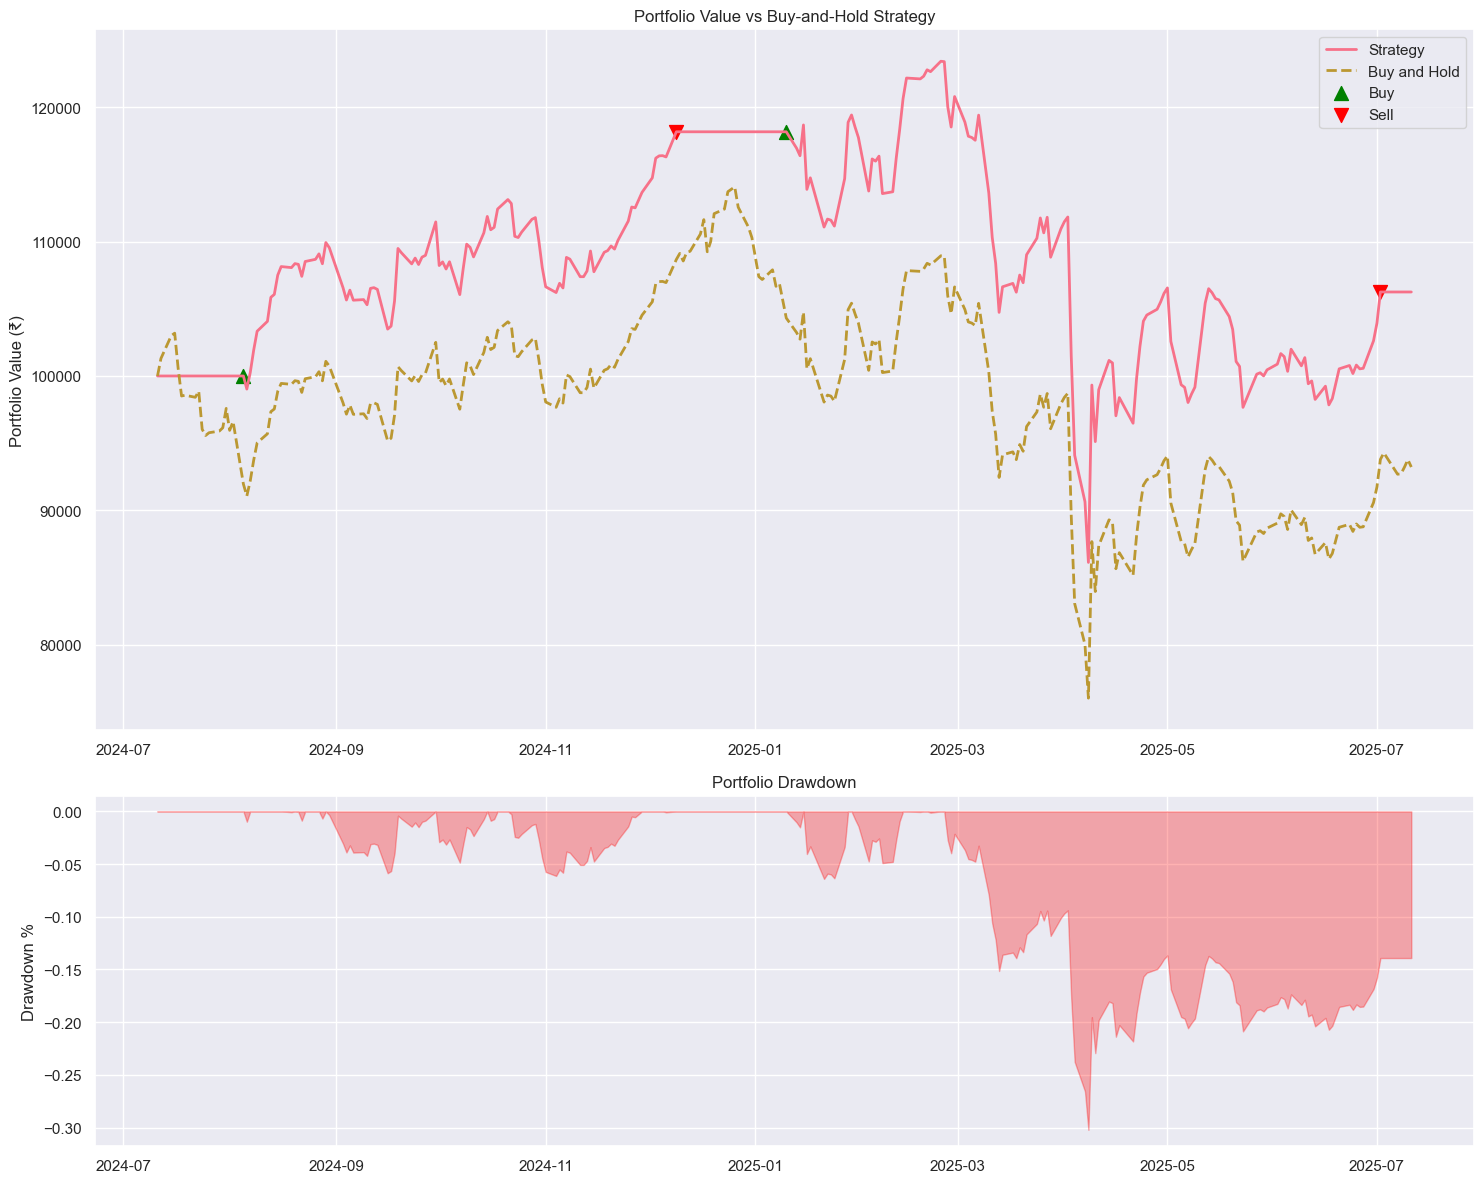

Plot saved to ../reports/figures/AAPL_returns_distribution.png


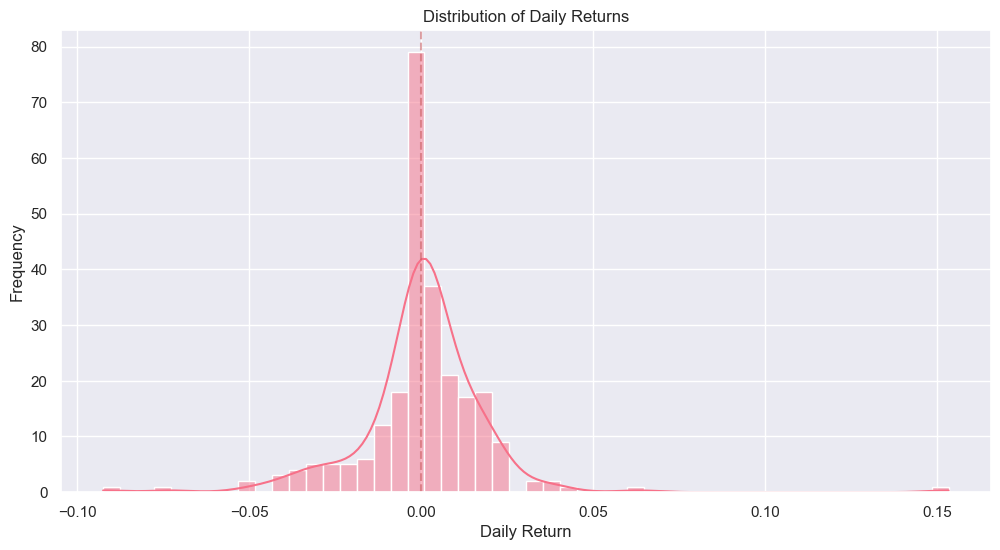


Sample of Trading History:
--------------------------------------------------
                          Action    Price  Quantity       Value
Date                                                           
2024-08-05 00:00:00-04:00    Buy 208.2959  480.0863 100000.0000
2024-12-09 00:00:00-05:00   Sell 246.1562  480.0863 118176.2301
2025-01-10 00:00:00-05:00    Buy 236.2800  500.1532 118176.2301
2025-07-02 00:00:00-04:00   Sell 212.4400  500.1532 106252.5558

Backtesting results for TSLA:
--------------------------------------------------
Cumulative_Return   :     0.5889
Annualized_Return   :     0.5918
Daily_Volatility    :       3.62%
Annualized_Volatility:      57.39%
Sharpe_Ratio        :     1.0313
Maximum_Drawdown    :     -38.65%
Win_Rate            :      66.67%
Number_of_Trades    :          7


C:\Users\techs\AppData\Local\Temp\ipykernel_90876\1748518799.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


Plot saved to ../reports/figures/TSLA_strategy_performance.png


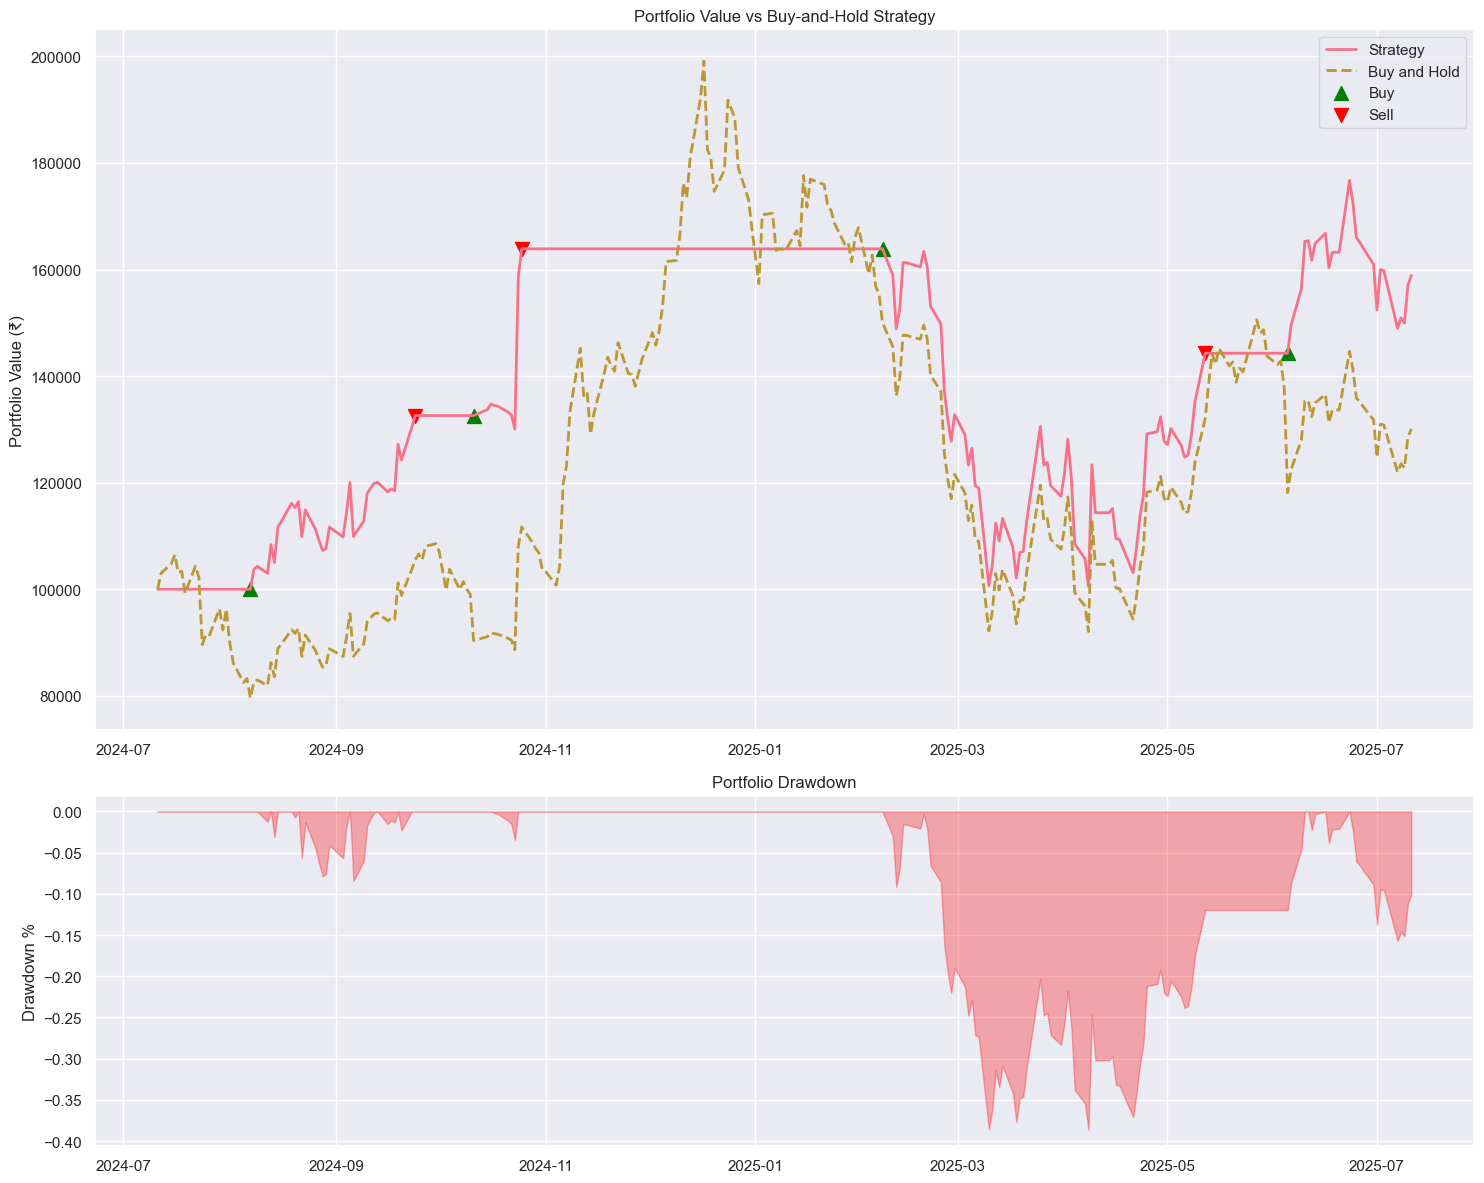

Plot saved to ../reports/figures/TSLA_returns_distribution.png


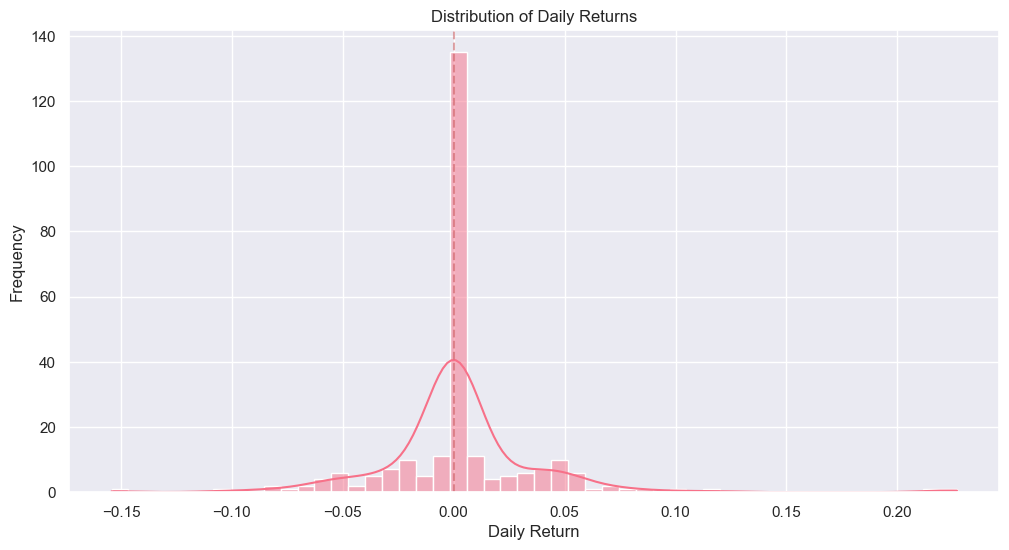


Sample of Trading History:
--------------------------------------------------
                          Action    Price  Quantity       Value
Date                                                           
2024-08-07 00:00:00-04:00    Buy 191.7600  521.4852 100000.0000
2024-09-24 00:00:00-04:00   Sell 254.2700  521.4852 132598.0452
2024-10-11 00:00:00-04:00    Buy 217.8000  608.8064 132598.0452
2024-10-25 00:00:00-04:00   Sell 269.1900  608.8064 163884.6080
2025-02-07 00:00:00-05:00    Buy 361.6200  453.1956 163884.6080

Backtesting results for MSFT:
--------------------------------------------------
Cumulative_Return   :    -0.0024
Annualized_Return   :    -0.0024
Daily_Volatility    :       1.52%
Annualized_Volatility:      24.09%
Sharpe_Ratio        :    -0.0100
Maximum_Drawdown    :     -21.83%
Win_Rate            :       0.00%
Number_of_Trades    :          2


C:\Users\techs\AppData\Local\Temp\ipykernel_90876\1748518799.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['Date'] = pd.to_datetime(data['Date'])


Plot saved to ../reports/figures/MSFT_strategy_performance.png


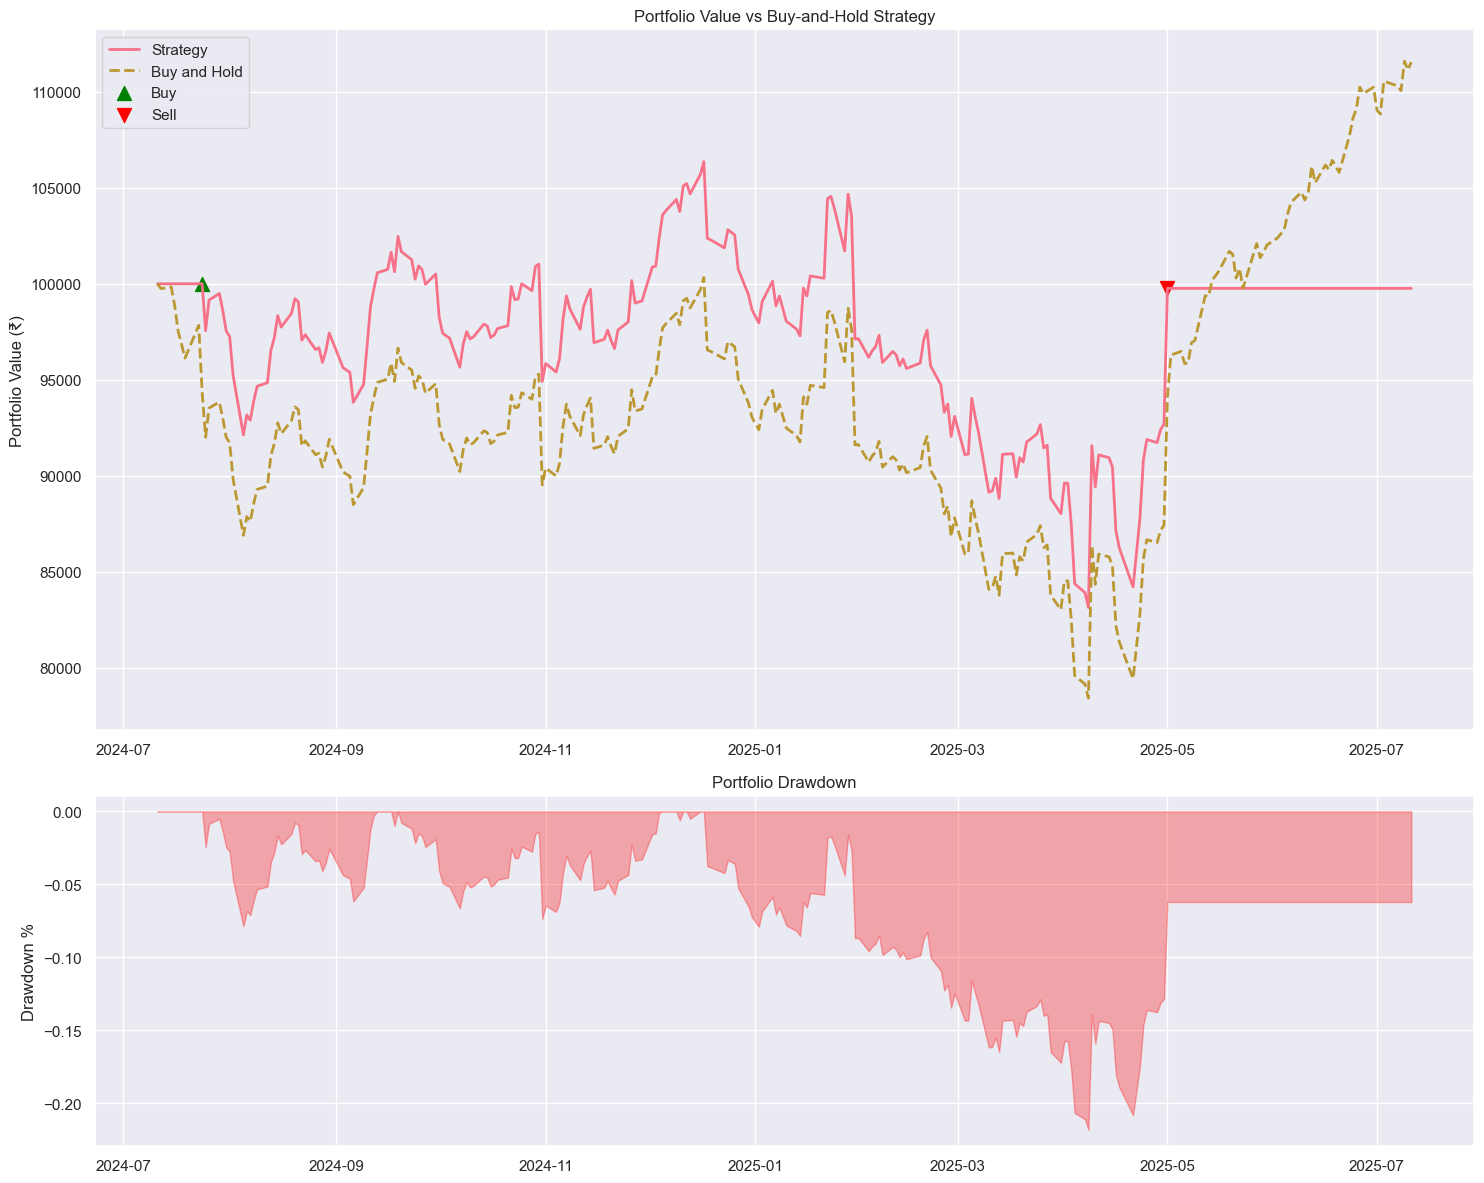

Plot saved to ../reports/figures/MSFT_returns_distribution.png


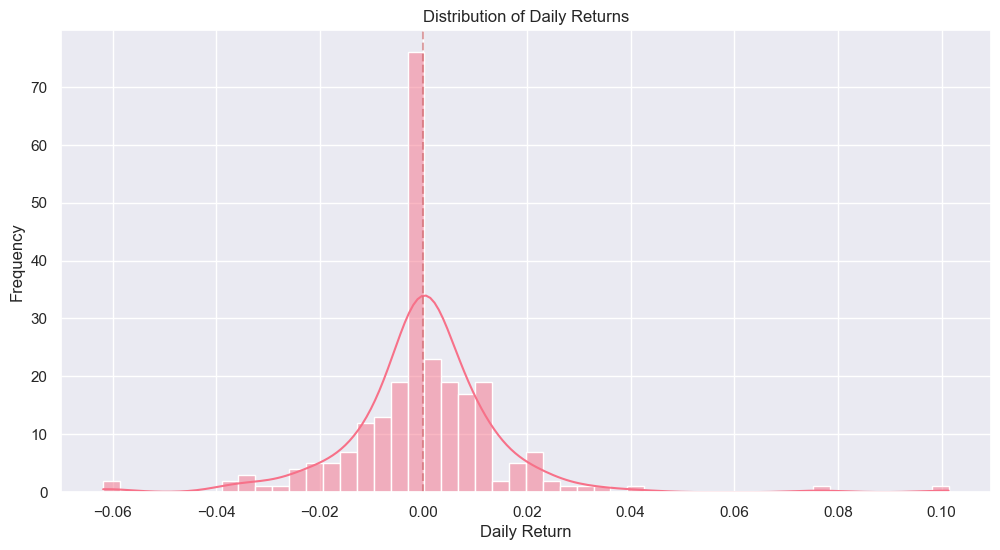


Sample of Trading History:
--------------------------------------------------
                          Action    Price  Quantity       Value
Date                                                           
2024-07-24 00:00:00-04:00    Buy 425.6367  234.9422 100000.0000
2025-05-01 00:00:00-04:00   Sell 424.6205  234.9422  99761.2506


In [5]:
# Define function to load and prepare data for backtesting
def load_data(symbol='AAPL'):
    """
    Load the test dataset with predictions for a given symbol
    
    Args:
        symbol (str): Stock symbol to load data for
        
    Returns:
        pd.DataFrame: Processed data ready for backtesting
    """
    # Load the test predictions
    data = pd.read_csv(f'../data/processed/{symbol}_test_predictions.csv')
    
    # Convert date and set as index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    # Sort by date
    data.sort_index(inplace=True)
    
    return data

# Create reports directory if it doesn't exist
os.makedirs('../reports/figures', exist_ok=True)

# Run backtesting for each stock
for symbol in ['AAPL', 'TSLA', 'MSFT']:
    print(f"\nBacktesting results for {symbol}:")
    print("-" * 50)
    
    # Load data
    data = load_data(symbol)
    
    # Create and run backtester
    backtester = Backtester(data)
    backtester.run_backtest()
    
    # Calculate performance metrics
    metrics = backtester.calculate_metrics()
    
    # Print metrics
    for metric, value in metrics.items():
        if metric in ['Daily_Volatility', 'Annualized_Volatility', 'Maximum_Drawdown', 'Win_Rate']:
            print(f"{metric:20}: {value*100:10.2f}%")
        elif metric == 'Number_of_Trades':
            print(f"{metric:20}: {int(value):10d}")
        else:
            print(f"{metric:20}: {value:10.4f}")
    
    # Plot and save strategy performance
    plot_strategy_performance(backtester, f'../reports/figures/{symbol}_strategy_performance.png')
    
    # Plot and save returns distribution
    plot_daily_returns_distribution(backtester, f'../reports/figures/{symbol}_returns_distribution.png')
    
    # Display sample of trades
    print("\nSample of Trading History:")
    print("-" * 50)
    trades_df = backtester.get_trades_history()
    if len(trades_df) > 0:
        print(trades_df.head())
